In [9]:
import mne
import numpy as np
import scipy
import h5py
import matplotlib
import warnings
import sys
import pandas as pd

sys.path.insert(0, '/Users/basilminkov/Scripts/python3/')
from Neuroimaging.data import load_data
from Neuroimaging.algorythms import test_rolling_variance_maximisation

%matplotlib inline
warnings.filterwarnings("ignore")  # Ignor warnings

import matplotlib.pyplot as plt
from scipy.signal import firwin, hilbert

fig_size = [8, 6]  # Set figure size
plt.rcParams["figure.figsize"] = fig_size

In [3]:
channels_path = "/Users/basilminkov/Scripts/python3/Neuroimaging/stat/chanlocs_mod.mat"
data_path = "/Users/basilminkov/Neuroscience/Data/Test/20.02.17/Alpha1_02-20_17-52-50/experiment_data.h5"
df, fs, p_names, channels = load_data(data_path)

fs: 500
all labels 32: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
selected channels 32: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
protocol_names: ['Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Rest', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Rest', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Rest', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock', 'Mock']


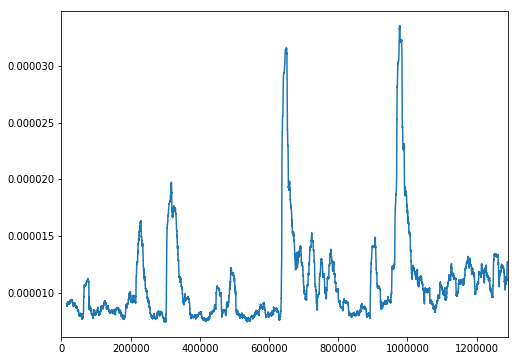

In [78]:
df['P4'].rolling(fs*30).std().plot()

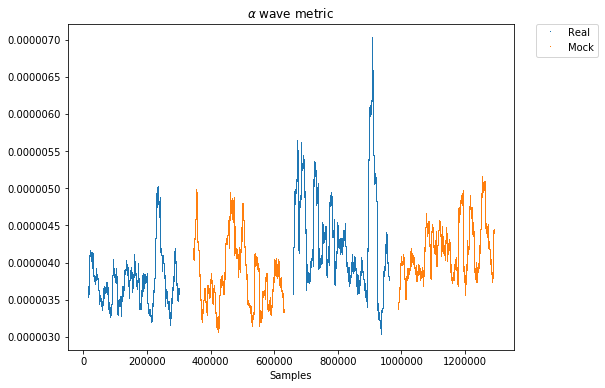

In [124]:
df['P4_filtered_hilbert'] = hilbert(df['P4_filtered'])

for name in ['Real', 'Mock']:
    plt.plot( 
        df.loc[df['block_name']==name, 'P4_filtered_hilbert'].abs().rolling(fs*30).mean(),
        ',',
        label = name
    )
plt.title(r'$\alpha$ wave metric')
plt.xlabel('Samples')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

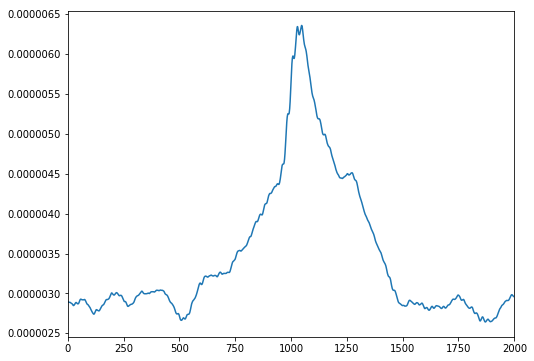

In [14]:
# trial averaging

file_path = "/Users/basilminkov/Neuroscience/Data/Test/20.02.17/Alpha1_02-20_17-52-50/experiment_data.h5"

with h5py.File(file_path) as f:
    data = [f['protocol{}/signals_data/'.format(k + 1)][:] for k in range(6)]    
    df = pd.DataFrame(np.concatenate(data))
   
# df[[0, 4]].plot()
    
df['diff'] = (df[0] > df[4]).apply(int).diff()

gap = 1000
ids = df.loc[df["diff"]==1].index

slises = {}

for i in ids[:-1]:
    slises[i] = np.array(df[0].iloc[np.arange(i-gap, i+gap)])
    
slises = pd.DataFrame(slises)

slises.mean(axis=1).plot()